# Using HDF5 file(s) as a database

HDF files can be considered databases itself, however `h5py` does not implementation query functions. This chapter will take you through everything you need to know to find data within one or more HDF5 files based on attributes or properties. The explanation will be conducted using practical examples.

In addition to the normal import, we will need some tutorial data:

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox import tutorial

h5tbx.use(None)

using("h5py")

## Test file

Throughout this section the following test file will be used:

In [2]:
filename = tutorial.generate_sample_file()
h5tbx.dump(filename)

## Attribute search

HDF attribute generally are describing groups or datasets and hence are ideal to search for.

One such attribute used in the test file is "standard_name". The `find` methods uses a filter argument `flt` of type dictionary, similar to MongoDB syntax. The return value will be a list of (lazy) objects:

In [3]:
with h5tbx.File(filename) as h5:
    res = h5.find(flt={'standard_name': 'velocity', 'units': 'm/s'})

res

[<LDataset "/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=14.2, standard_name=velocity, units=m/s)>,
 <LDataset "/group2/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=30.2, units=m/s, standard_name=velocity)>,
 <LDataset "/group1/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=velocity, units=m/s)>]

If we are only interested in the first occurrence, then `find_one` should be used.

In [4]:
with h5tbx.File(filename) as h5:
    res = h5.find_one(flt={'standard_name': 'velocity', 'units': 'm'})

res

Both function are also part of the `database` module and can be called on HDF5 filenames:

In [5]:
res_find = h5tbx.database.find(filename, flt={'standard_name': 'velocity'})
assert len(res_find) == 3
res_one = h5tbx.database.find_one(filename, flt={'standard_name': 'velocity'})

### Property search

It might be reasonable to search for properties of HDF5 objects, like a specific shape, dimension etc.. For this, a dollar sign must be added to the property name:

In [6]:
h5tbx.database.find(filename, flt={'$ndim': 0})

[<LDataset "/group2/z" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=z_coordinate, units=m)>]

Let's search for all velocity datasets in the file. Velocity datasets are indicated by the attribute "standard_name":

In [7]:
with h5tbx.File(filename) as h5:
    res = h5.find(flt={'standard_name': 'velocity'})

res

[<LDataset "/group1/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=velocity, units=m/s)>,
 <LDataset "/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=14.2, standard_name=velocity, units=m/s)>,
 <LDataset "/group2/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=30.2, units=m/s, standard_name=velocity)>]

If we are only interested in the **first** occurrence, then `find_one()` does the job:

In [8]:
with h5tbx.File(filename) as h5:
    res = h5.find_one(flt={'standard_name': 'velocity'})

res

<LDataset "/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=14.2, standard_name=velocity, units=m/s)>

## Object filter
By providing `objfilter=dataset` or `objfilter=group` only those type of objects are include in the result:

In [9]:
h5tbx.database.find(filename, flt={'check_value': {'$exists': True}}, objfilter='group')

[<LGroup "/group1" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf">,
 <LGroup "/" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf">,
 <LGroup "/group2" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf">]

## Special operators

### "$exists"

In the below example, all objects that have an attribute "units" are returned

In [10]:
results = h5tbx.database.find(filename, {'units': {'$exists': True}})
results

[<LDataset "/group2/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=30.2, units=m/s, standard_name=velocity)>,
 <LDataset "/group2/pressure2" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=-10.3, standard_name=pressure, units=kPa)>,
 <LDataset "/group1/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=velocity, units=m/s)>,
 <LDataset "/group2/z" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=z_coordinate, units=m)>,
 <LDataset "/pressure1" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=pressure, units=Pa, check_value=-140.3)>,
 <LDataset "/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=14.2, standard_name=velocity, units=m/s)>]

### $regex

Regex expressions are usefull to find objects by path name pattern:

In [11]:
results = h5tbx.database.find(filename, {'$name': {'$regex': '^.*/velocity$'}})
results

[<LDataset "/group2/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=30.2, units=m/s, standard_name=velocity)>,
 <LDataset "/group1/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(standard_name=velocity, units=m/s)>,
 <LDataset "/velocity" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=14.2, standard_name=velocity, units=m/s)>]

### $basename

"Basename" is not a property but could be useful. It is implemented as an "virtual property": 

In [12]:
results = h5tbx.database.find(filename, {'$basename': 'pressure2'})
results

[<LDataset "/group2/pressure2" in "C:\Users\Matthias\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_4\tmp0.hdf" attrs=(check_value=-10.3, standard_name=pressure, units=kPa)>]

### Mathematical operation (>, >=, <, <=)

The datasets and groups in the example files all have the attribute "check_value", let's identify objects that match certain values of this attribute:

In [13]:
print('object names with check value greater than 0.1:')

results = h5tbx.database.find(filename, {'check_value': {'$gt': 0.1}})
for r in results:
    print('  ', r.name)


print('\nobject names with check value equal to 0:')

results = h5tbx.database.find(filename, {'check_value': {'$eq': 0}})
for r in results:
    print('  ', r.name)


print('\nobject names with check value lower equal -3.3:')


results = h5tbx.database.find(filename, {'check_value': {'$lte': -3.3}})
for r in results:
    print('  ', r.name)

object names with check value greater than 0.1:
   /group2/velocity
   /velocity

object names with check value equal to 0:
   /group2
   /group1
   /

object names with check value lower equal -3.3:
   /pressure1
   /group2/pressure2


### User-defined operator

Let's take the regex example and turn it into a new operator:

The regex query filter `"{'$name': {'$regex': '^.*/velocity$'}}"` means, that we are looking for "basenames" of objects, so not the full internal HDF5 path but the name.

All operator functions are stored in `database.hdfdb.query`. In fact, the `"$basename"`-operator exists, so we first delete it and add it again by our own function:

In [14]:
from h5rdmtoolbox.database.hdfdb import query

# note, all operator functions are stored in this dictionary: query.operator
query.operator.pop('$basename', None)  # remove existing operator

def my_basename_operator(obj_name, basename) -> bool:
    """calling regex under the hood"""
    print(f'Checking if basename of object name "{obj_name}" is matching pattern "^.*/{basename}$"')
    return query._regex(obj_name, pattern=f'^.*/{basename}$')

query.operator['$basename'] = my_basename_operator

In [15]:
results = h5tbx.database.find(filename, {'$name': {'$basename': 'velocity'}}, 'dataset')

for r in results:
    print(r.name)

Checking if basename of object name "/group1/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/pressure2" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/z" is matching pattern "^.*/velocity$"
Checking if basename of object name "/pressure1" is matching pattern "^.*/velocity$"
Checking if basename of object name "/velocity" is matching pattern "^.*/velocity$"
/group2/velocity
/group1/velocity
/velocity


**Working with the results**

Let's investigate the return values of queries. The method `find_one` returns a so-called "lazy" object, and the `find` method a generator of this class.

Checking if basename of object name "/group1/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/pressure2" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/z" is matching pattern "^.*/velocity$"
Checking if basename of object name "/pressure1" is matching pattern "^.*/velocity$"
Checking if basename of object name "/velocity" is matching pattern "^.*/velocity$"


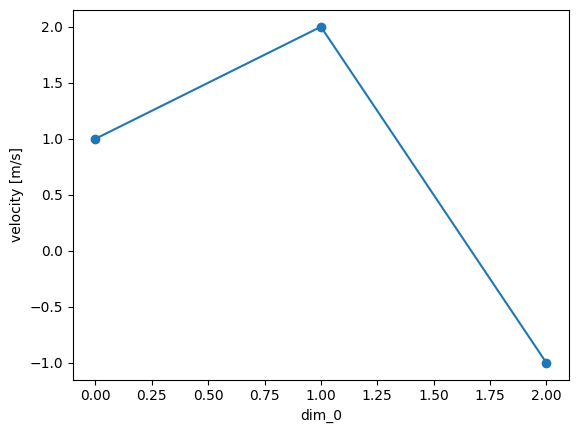

In [16]:
results = h5tbx.database.find_one(filename, {'$name': {'$basename': 'velocity'}}, 'dataset')

# let's directly plot the result:
results[()].plot(marker='o')